# Title: Logistic regression 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_ohe = pd.read_csv("data_ohe.csv") # One-hot encoded
print('Data one-hot encoded shape', data_ohe.shape)
data_ohe.head()

Data one-hot encoded shape (368, 152)


,sample_id,group,age,Alanine,Creatine,Creatinine,Glutamine,Glycine,Histidine,Isoleucine,...,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
0,6,2,72,0.411,0.016,0.088,0.705,0.274,0.063,0.077,...,1,0,0,0,0,1,0,0,1,0
1,7,2,89,0.379,0.018,0.069,0.696,0.538,0.034,0.062,...,1,0,0,0,1,0,0,0,0,1
2,9,2,82,0.362,0.058,0.117,0.657,0.311,0.054,0.054,...,1,0,0,0,1,0,0,0,1,0
3,19,2,56,0.394,0.007,0.100,0.783,0.227,0.067,0.084,...,1,0,0,0,0,1,0,1,0,0
4,20,2,87,0.224,0.122,0.155,0.452,0.220,0.055,0.033,...,1,0,0,0,0,1,0,0,0,1


# Prepare data for modeling

In [3]:
# Prepare data for modeling
data_mod=data_ohe.drop(['age', 'sample_id'], axis=1)
print('Shape of onehot encoded data ready for modeling:', data_mod.shape)

# Create X/y variables
X = data_mod.drop(["group"], axis=1)
y = data_mod.group

Shape of onehot encoded data ready for modeling: (368, 150)


In [4]:
from sklearn.model_selection import train_test_split

# Create X/y variables

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
)

%store y_te

print("Train:", X_tr.shape, y_tr.shape)
print("Test:", X_te.shape, y_te.shape)

Stored 'y_te' (Series)
Train: (257, 149) (257,)
Test: (111, 149) (111,)


In [5]:
# Check the number of samples (patients) in each group
print(y_tr.value_counts())
print(y_tr.value_counts(normalize=True))

2    172
0     66
1     19
Name: group, dtype: int64
2    0.669261
0    0.256809
1    0.073930
Name: group, dtype: float64


**Comment:** There are 172 patients in the group 2 (acute phase of infection), 66 patients in the group 0 (Post-COVID) and 19 patients in the group 1 (post-acute phase of infection). The data is imbalanced and therefore, the logistic regression will be implemented with the parameter: class_weight='balanced'.

# Baseline

## Most frequent

In [6]:
# The most frequent baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(None, y_tr)
baseline_dummy_score=100 * dummy.score(None, y_te)
%store baseline_dummy_score
print('Test score', np.round(baseline_dummy_score,3))

Stored 'baseline_dummy_score' (float64)
Test score 66.667


## Logistic regression, no tuning

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Logistic regression estimator
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(class_weight='balanced'))])

# Fit estimator
logreg_pipe.fit(X_tr, y_tr)

# Evaluate on test set
baseline_logreg_score = logreg_pipe.score(X_te, y_te)*100
%store baseline_logreg_score
print('Test score', np.round(baseline_logreg_score,3))

Stored 'baseline_logreg_score' (float64)
Test score 80.18


In [8]:
from sklearn.metrics import classification_report

# Classification report
y_te_preds = logreg_pipe.predict(X_te)
print(classification_report(y_true=y_te, y_pred=y_te_preds))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75        28
           1       0.27      0.33      0.30         9
           2       0.93      0.86      0.90        74

    accuracy                           0.80       111
   macro avg       0.64      0.66      0.65       111
weighted avg       0.82      0.80      0.81       111



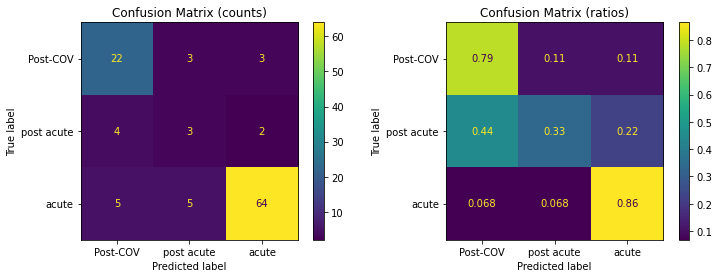

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_pipe.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_pipe.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

## k-NN, no tuning

In [10]:
# The knn baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=10))]
)

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
baseline_knn_score = knn_pipe.score(X_te, y_te)*100
%store baseline_knn_score
print('Test score', np.round(baseline_knn_score,3))

Stored 'baseline_knn_score' (float64)
Test score 81.081


# Grid search with cross-validation: all features

**Comment:** In the following, two strategies will be tested in building a model for the multiclass classfication: the multinomial based on the softmax regression and the ovr that converts the multiclass classification problem into several binary classifications.

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)

from sklearn.model_selection import GridSearchCV

# Logistic regression estimator
logreg_estimator = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(class_weight='balanced'))])

# Grid search with cross-validation
Cs = np.logspace(-3, -1, num=20)

grids = [{"logreg__penalty": ["l2"], "logreg__multi_class": ["ovr"], "logreg__solver": ["liblinear"], "logreg__C": Cs},
   {"logreg__penalty": ["l2"], "logreg__multi_class": ["multinomial"], "logreg__solver": ["saga"],"logreg__C": Cs}]

logreg_gscv = GridSearchCV(logreg_estimator, grids, cv=10, refit=True, return_train_score=True, verbose=1)

In [12]:
# Fit  estimator
logreg_gscv.fit(X_tr, y_tr)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'logreg__C': array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.0615848...
                         {'logreg__C': array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ]),
                          'logreg__multi_class': ['multinomial'],
                          'logreg__penalty': ['l2'],
                          'logreg__solver': ['saga']}],
             return_train_score=True, verbose=1)

In [13]:
# Collect results in a DataFrame
logreg_results = pd.DataFrame(
    {
        "strategy": logreg_gscv.cv_results_["param_logreg__multi_class"],
        "C": logreg_gscv.cv_results_["param_logreg__C"],
        "mean_tr": logreg_gscv.cv_results_["mean_train_score"],
        "mean_te": logreg_gscv.cv_results_["mean_test_score"],
        "std_te": logreg_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean test score
logreg_results.sort_values(by="mean_te", ascending=False).head(5)

,strategy,C,mean_tr,mean_te,std_te
19,ovr,0.1,0.927803,0.825077,0.053316
18,ovr,0.078476,0.922621,0.825077,0.053316
17,ovr,0.061585,0.912674,0.817385,0.052489
15,ovr,0.037927,0.893648,0.809692,0.058623
16,ovr,0.048329,0.903163,0.809692,0.058623


In [14]:
# Print the best estimator
logreg_gscv.best_estimator_.named_steps['logreg']

LogisticRegression(C=0.07847599703514611, class_weight='balanced',
                   multi_class='ovr', solver='liblinear')

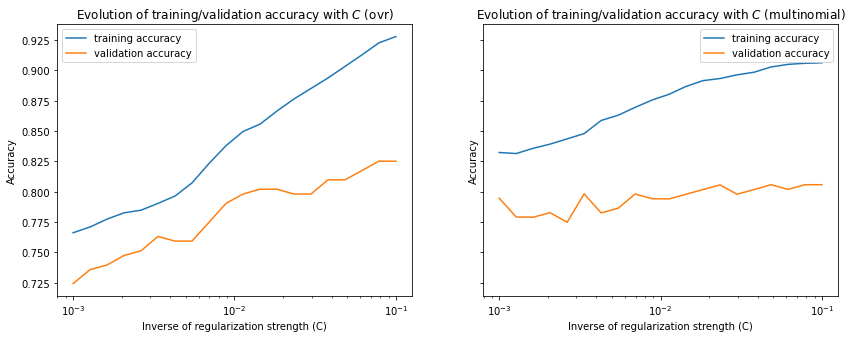

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

logreg_results_ovr=logreg_results[logreg_results['strategy']=='ovr']
logreg_results_multin=logreg_results[logreg_results['strategy']=='multinomial']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot training/validation accuracy curves
ax1.semilogx(logreg_results_ovr["C"], logreg_results_ovr["mean_tr"], label='training accuracy')
ax1.semilogx(logreg_results_ovr["C"], logreg_results_ovr["mean_te"],  label='validation accuracy')

ax1.set_xlabel('Inverse of regularization strength (C)')
ax1.set_ylabel('Accuracy')
ax1.legend(loc="best")
ax1.set_title("Evolution of training/validation accuracy with $C$ (ovr)")

# Plot training/validation accuracy curves
ax2.semilogx(logreg_results_multin["C"], logreg_results_multin["mean_tr"], label='training accuracy')
ax2.semilogx(logreg_results_multin["C"], logreg_results_multin["mean_te"],  label='validation accuracy')

ax2.set_xlabel('Inverse of regularization strength (C)')
ax2.set_ylabel('Accuracy')
ax2.legend(loc="best")
ax2.set_title("Evolution of training/validation accuracy with $C$ (multinomial)")

plt.show()

**Comment:** 
- The one-vs-rest strategy for the multiclass classfication gives better results in terms of the validation accuracy than the multinomial strategy (based on the softmax regression). In the ovr strategy, a binary classfier is fit to separate each class from the other ones.  
- Both models overfit: the difference between the training and the validation accuracy grows with increasing C parameter (so with decreasing regularization strength). Therefore, regularization is needed here to fight the overfitting. Above, the grid search was limited to C parameter < 0.1 to minimize the generalization error with the price of the validation accuracy decrease (the original grid search was done with C in the range (Cs = np.logspace(-3, -3, num=20))). The model with the 149 features seems to be too complex to fit the 257 datapoints.

In [16]:
from sklearn.metrics import classification_report

logreg_gscv.predict(X_te)

test_score_logreg=logreg_gscv.score(X_te, y_te)*100
%store test_score_logreg
print('Test score', np.round(test_score_logreg,3))

# Classification report
y_te_preds_logreg = logreg_gscv.predict(X_te)
%store y_te_preds_logreg
print(classification_report(y_true=y_te, y_pred=y_te_preds_logreg))

# Extract probabilities
prob_logreg = logreg_gscv.predict_proba(X_te)
%store prob_logreg

Stored 'test_score_logreg' (float64)
Test score 80.18
Stored 'y_te_preds_logreg' (ndarray)
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        28
           1       0.31      0.44      0.36         9
           2       0.94      0.82      0.88        74

    accuracy                           0.80       111
   macro avg       0.66      0.71      0.68       111
weighted avg       0.83      0.80      0.81       111

Stored 'prob_logreg' (ndarray)


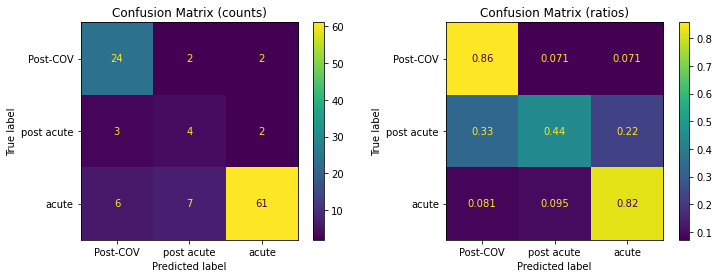

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** The accuracy of the tuned logistic regression model fit on data with all features is the same as the accuracy obtained with the classfier with no tuning: 80.18%. The proportions of correctly classfied and misclassified patients changed slightly when compared to the baseline.

**Comment:** 
- The model detects patients in the acute phase of infection 82% of times. Among the 74 patients in the acute phase, 7 were misclassfied as being in the post-acute phase and 6 of them as being completely recovered (post-COVID). If I would like the model to be more sensitive for detecting patients in the acute phase, I may want to increase the recall by decreasing the treshold of probabilities that the classfication is based on. The metabolome/lipidome of the misclassfied patients may be similar to the recovered patients for a number of reasons (good immunity and/or young age etc.) The model precision to detect patients in the acute phase is 94%, meaning that when it predicts acute phase, it is correct 94% of times. 
- The model detects the post-COVID patients 86% of times. The precision of the model to detect these patients is actually lower than the recall. 
- The model misclassfied 5 out of the 9 post acute phase patients. It means that in the 4 correctly classfied patients there is an unique pattern in the quantities of the metabolites/lipids that makes it possible for them to be distinguished from the patients in the two extreme groups 0 and 2 (post-COVID and the acute phase). The misclassfied ones instead seem to be similar in terms of their metabolome/lipidome to either the recovered patients (3) or the patients in the acute phase (2). The model predicts 13 post-acute patients overall, but only 4 of them correctly.

## Feature importance based on coefficients

In the following, I will look at the features that have the highest coefficients for each category.

In [18]:
# Access coefficients of the model
coefficients=logreg_gscv.best_estimator_.named_steps['logreg'].coef_
coefficients=pd.DataFrame(coefficients, columns=list(X_tr.columns))
coefficients.shape

(3, 149)

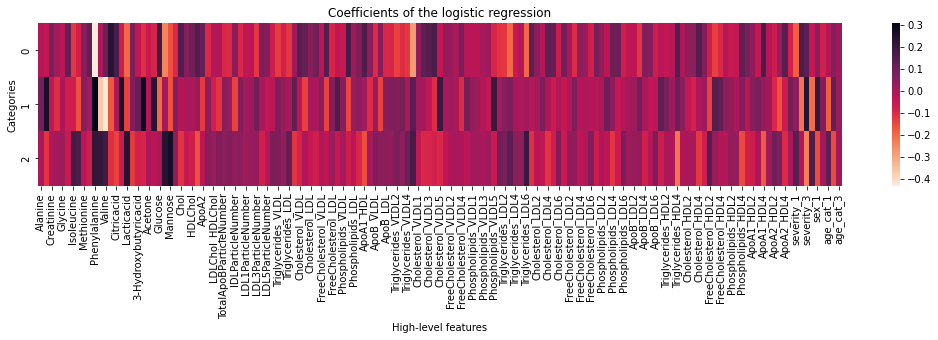

In [19]:
# Plot heatmap with the coefficients of the model
plt.figure(figsize=(18,3))
sns.heatmap(coefficients, cmap = sns.cm.rocket_r)

plt.xlabel('High-level features')
plt.ylabel('Categories')
plt.title("Coefficients of the logistic regression")
plt.show()

In [20]:
logreg_gscv.best_estimator_.classes_

array([0, 1, 2], dtype=int64)

**Comment:** The positive coefficients in each category predict the associated class. 

Examples:

In [21]:
coefficients['Phenylalanine']

0   -0.431651
1    0.309397
2    0.210615
Name: Phenylalanine, dtype: float64

In [22]:
coefficients['Acetoaceticacid']

0   -0.107282
1    0.281649
2   -0.085553
Name: Acetoaceticacid, dtype: float64

In [23]:
# Sort the coeffcients from the highest to the lowest for each class and store in a DataFrame
feat_highest_coef=[]
for label in range(3):
    feat_highest_coef.append(coefficients.T.iloc[:,label].sort_values(ascending=False).index.tolist())
    
highest_coef=[]
for label in range(3):
    highest_coef.append(list(coefficients.T.iloc[:,label].sort_values(ascending=False)))

In [24]:
# Create df with the names of the top features
feat_highest_coef=pd.DataFrame(feat_highest_coef)
feat_highest_coef.index=['post_COV','post_acute', 'acute']
feat_highest_coef=feat_highest_coef.T
feat_highest_coef.head(15)

,post_COV,post_acute,acute
0,Aceticacid,Phenylalanine,Mannose
1,Glucose,Acetoaceticacid,Glycoproteins
2,Phospholipids_IDL,Creatine,Lacticacid
3,Citricacid,Formicacid,Phenylalanine
4,Cholesterol_VLDL4,Pyruvicacid,Tyrosine
5,ApoA1_HDL4,severity_3,Triglycerides_LDL6
6,severity_2,sex_1,Valine
7,ApoA1_HDL,Phospholipids_VLDL5,Isoleucine
8,ApoA1,Cholesterol_VLDL5,Triglycerides_VLDL5
9,Chol,FreeCholesterol_HDL,Leucine


**Comment:** In the table above, the features with the highest coeffcients for each category are shown. It is noteworthy that the categorical features are of high importance in the classfication. 

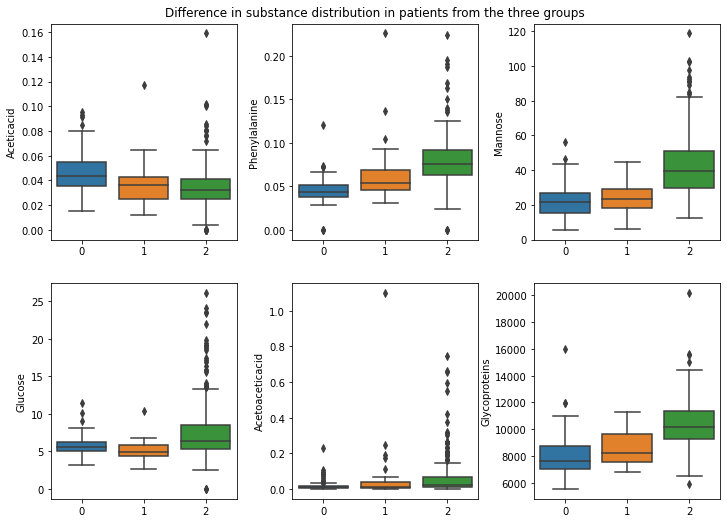

In [25]:
# Take the first two rows from the DataFrame above
features_to_check=list(feat_highest_coef.iloc[0,:])+list(feat_highest_coef.iloc[1,:])

fig, axes = plt.subplots(nrows = 2,
                        ncols = 3,
                        figsize = (12,8),
                        gridspec_kw = {"wspace": 0.3,  # Sets the width of padding between subplots (is a fraction of the Axes width)
                                       "hspace": 0.2,
                                        "width_ratios": [ 1, 1, 1] # Sets relative width ratios between subplots 
                                       })

for feat, ax in zip(range(0, len(features_to_check)), axes.ravel()):
    
    # Plot the box plot
    sns.boxplot(x=data_ohe["group"], y=data_ohe[features_to_check[feat]], data=data_ohe, ax=ax)
    ax.set(xlabel=None)
fig.suptitle("Difference in substance distribution in patients from the three groups") 
fig.subplots_adjust(top=0.95)
plt.show()

In [26]:
# Create df with the top coefficients
highest_coef=pd.DataFrame(highest_coef)
highest_coef.index=['post_COV','post_acute', 'acute']
highest_coef=highest_coef.T
highest_coef.head(5)

,post_COV,post_acute,acute
0,0.235794,0.309397,0.270974
1,0.179739,0.281649,0.238893
2,0.169775,0.261498,0.235239
3,0.169645,0.259565,0.210615
4,0.166240,0.238344,0.208000


Stored 'post_covid_feat' (Series)


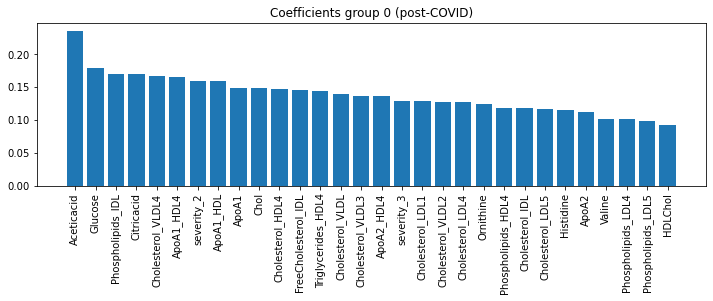

In [27]:
# Plot the coefficients for group 1 (post-acute phase)
post_covid_feat=feat_highest_coef['post_COV']
%store post_covid_feat
post_covid_coef=highest_coef['post_COV']

plt.figure(figsize=(12,3))
plt.bar(post_covid_feat[:30], post_covid_coef[:30])
plt.xticks(rotation=90)
plt.title("Coefficients group 0 (post-COVID)")
plt.show()

Stored 'acute_feat' (Series)


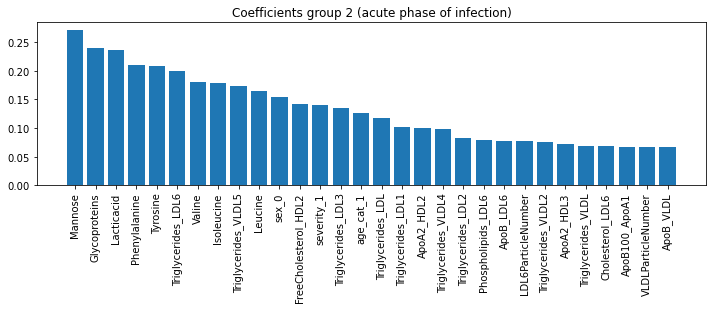

In [28]:
# Plot the coefficients for group 2 (acute phase)
acute_feat=feat_highest_coef['acute']
%store acute_feat
acute_coef=highest_coef['acute']

plt.figure(figsize=(12,3))
plt.bar(acute_feat[:30], acute_coef[:30])
plt.xticks(rotation=90)
plt.title("Coefficients group 2 (acute phase of infection)")
plt.show()

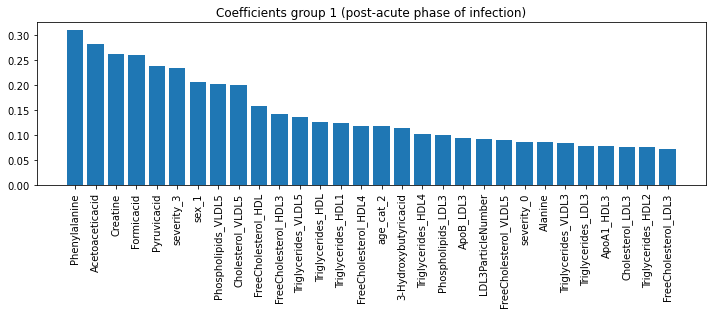

In [29]:
# Plot the coefficients for group 1 (post-acute phase)
post_acute_feat=feat_highest_coef['post_acute']
post_acute_coef=highest_coef['post_acute']

plt.figure(figsize=(12,3))
plt.bar(post_acute_feat[:30], post_acute_coef[:30])
plt.xticks(rotation=90)
plt.title("Coefficients group 1 (post-acute phase of infection)")
plt.show()

**Comment:** If some features have high coeffcient in two classes, like for example Phenylalanine, then some patients with certain quantity of the substance corresponding to this feature may be misclassfied. For example, Phenylalanine has a high coefficient for classes 1 and 2, but low for class 0. Some post acute phase patients may have increased level of Phenylalanine and the classfier may have trouble predicting whether the patients are in the acute or the post acute phase of infection.

# SMOTE

In [30]:
# Oversample with SMOTE and random undersample for imbalanced dataset

from collections import Counter
from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(y_tr)
print(counter)

# transform the dataset
sm = SMOTE(sampling_strategy = {2: 172, 0: 66, 1: 66})
X_tr_bal, y_tr_bal = sm.fit_resample(X_tr, y_tr)

# summarize the new class distribution
counter = Counter(y_tr_bal)
print(counter)

Counter({2: 172, 0: 66, 1: 19})
Counter({2: 172, 1: 66, 0: 66})


In [31]:
# Logistic regression estimator
logreg_estimator = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression())])  

# Grid search with cross-validation
Cs = np.logspace(-3, 3, num=20)

grids = [{"logreg__penalty": ["l2"], "logreg__multi_class": ["ovr"], "logreg__solver": ["liblinear"], "logreg__C": Cs}]

logreg_gscv = GridSearchCV(logreg_estimator, grids, cv=10, refit=True, return_train_score=True, verbose=1)

In [32]:
# Fit  estimator
logreg_gscv.fit(X_tr_bal, y_tr_bal)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid=[{'logreg__C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'logreg__multi_class': ['ovr'],
                          'logreg__penalty': ['l2'],
                          'logreg__solver': ['liblinear']}],
             return_train_score=True, verbose=1)

In [33]:
# Collect results in a DataFrame
logreg_results = pd.DataFrame(
    {
        "strategy": logreg_gscv.cv_results_["param_logreg__multi_class"],
        "C": logreg_gscv.cv_results_["param_logreg__C"],
        "mean_tr": logreg_gscv.cv_results_["mean_train_score"],
        "mean_te": logreg_gscv.cv_results_["mean_test_score"],
        "std_te": logreg_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean test score
logreg_results.sort_values(by="mean_te", ascending=False).head(5)

,strategy,C,mean_tr,mean_te,std_te
8,ovr,0.335982,0.980269,0.905161,0.068330
12,ovr,6.158482,1.000000,0.898817,0.080958
10,ovr,1.43845,0.991230,0.898602,0.075727
11,ovr,2.976351,0.996711,0.895484,0.077328
7,ovr,0.162378,0.969669,0.895269,0.072215


In [34]:
# Print the best estimator
logreg_gscv.best_estimator_.named_steps['logreg']

LogisticRegression(C=0.3359818286283781, multi_class='ovr', solver='liblinear')

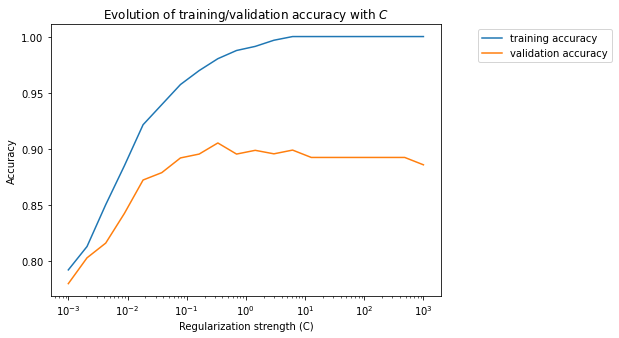

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.semilogx(logreg_results["C"], logreg_results["mean_tr"], label='training accuracy')
plt.semilogx(logreg_results["C"], logreg_results["mean_te"],  label='validation accuracy')

plt.xlabel('Regularization strength (C)')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.title("Evolution of training/validation accuracy with $C$")
plt.show()

**Comment:** 
- The model fit to data with the PCA-reduced dimensionality overfits much less than the model fit to data with all features, even with small regularization strength.

In [36]:
from sklearn.metrics import classification_report

test_score_logreg_smote=logreg_gscv.score(X_te, y_te)*100
%store test_score_logreg_smote
print('Test score', np.round(test_score_logreg_smote,3))

# Classification report
y_te_preds_logreg_smote = logreg_gscv.predict(X_te)
%store y_te_preds_logreg_smote
print(classification_report(y_true=y_te, y_pred=y_te_preds_logreg_smote))

# Extract probabilities
prob_logreg_smote = logreg_gscv.predict_proba(X_te)
%store prob_logreg_smote

Stored 'test_score_logreg_smote' (float64)
Test score 81.982
Stored 'y_te_preds_logreg_smote' (ndarray)
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        28
           1       0.30      0.33      0.32         9
           2       0.93      0.88      0.90        74

    accuracy                           0.82       111
   macro avg       0.66      0.68      0.67       111
weighted avg       0.83      0.82      0.82       111

Stored 'prob_logreg_smote' (ndarray)


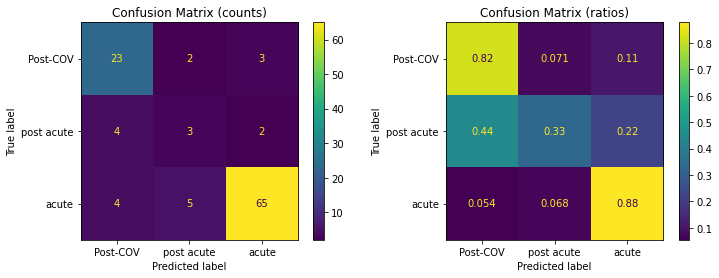

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

# PCA

**Comment:** In this part, I first reduce the dimensionality of the dataset using PCA (12 Principal Components) and then I fit the logistic regression model. 

In [38]:
# Standarize data
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale the train and test data prior to PCA
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [39]:
from sklearn.decomposition import PCA

# Create PCA transformer
pca = PCA(n_components=12)

# Apply PCA to rescaled data
X_tr_12d_rescaled = pca.fit_transform(X_tr_rescaled)
X_te_12d_rescaled = pca.transform(X_te_rescaled)

In [40]:
# Logistic regression estimator
logreg_estimator = Pipeline([("scaler", None), ("logreg", LogisticRegression(class_weight='balanced'))]) # No StandradScaler() because data scaled prior to PCA

# Grid search with cross-validation
Cs = np.logspace(-3, 3, num=20)

grids = [{"logreg__penalty": ["l2"], "logreg__multi_class": ["ovr"], "logreg__solver": ["liblinear"], "logreg__C": Cs}]

logreg_gscv = GridSearchCV(logreg_estimator, grids, cv=10, refit=True, return_train_score=True, verbose=1)

In [41]:
# Fit  estimator
logreg_gscv.fit(X_tr_12d_rescaled, y_tr)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'logreg__C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'logreg__multi_class': ['ovr'],
                          'logreg__penalty': ['l2'],
                          'logreg__solver': ['liblinear']}],
             return_train_score=True, verbose=1)

In [42]:
# Collect results in a DataFrame
logreg_results = pd.DataFrame(
    {
        "strategy": logreg_gscv.cv_results_["param_logreg__multi_class"],
        "C": logreg_gscv.cv_results_["param_logreg__C"],
        "mean_tr": logreg_gscv.cv_results_["mean_train_score"],
        "mean_te": logreg_gscv.cv_results_["mean_test_score"],
        "std_te": logreg_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean test score
logreg_results.sort_values(by="mean_te", ascending=False).head(5)

,strategy,C,mean_tr,mean_te,std_te
10,ovr,1.43845,0.865120,0.837385,0.065075
11,ovr,2.976351,0.868144,0.837385,0.065075
18,ovr,483.293024,0.872039,0.833385,0.063544
17,ovr,233.572147,0.871173,0.833385,0.063544
16,ovr,112.883789,0.871173,0.833385,0.063544


In [43]:
# Print the best estimator
logreg_gscv.best_estimator_.named_steps['logreg']

LogisticRegression(C=1.438449888287663, class_weight='balanced',
                   multi_class='ovr', solver='liblinear')

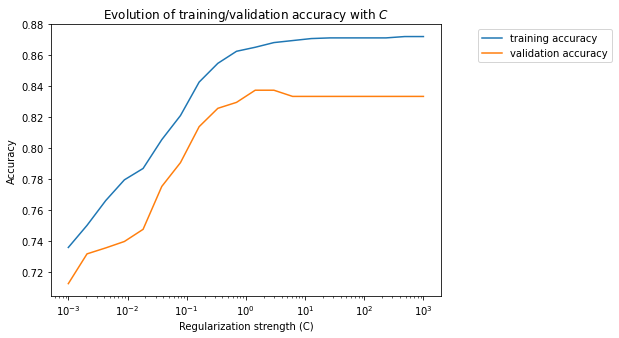

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.semilogx(logreg_results["C"], logreg_results["mean_tr"], label='training accuracy')
plt.semilogx(logreg_results["C"], logreg_results["mean_te"],  label='validation accuracy')

plt.xlabel('Regularization strength (C)')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.title("Evolution of training/validation accuracy with $C$")
plt.show()

**Comment:** 
- The model fit to data with the PCA-reduced dimensionality overfits much less than the model fit to data with all features, even with small regularization strength.

In [45]:
from sklearn.metrics import classification_report

test_score_logreg_pca=logreg_gscv.score(X_te_12d_rescaled, y_te)*100
%store test_score_logreg_pca
print('Test score', np.round(test_score_logreg_pca,3))

# Classification report
y_te_preds_logreg_pca = logreg_gscv.predict(X_te_12d_rescaled)
%store y_te_preds_logreg_pca
print(classification_report(y_true=y_te, y_pred=y_te_preds_logreg_pca))

# Extract probabilities
prob_logreg_pca = logreg_gscv.predict_proba(X_te_12d_rescaled)
%store prob_logreg_pca

Stored 'test_score_logreg_pca' (float64)
Test score 78.378
Stored 'y_te_preds_logreg_pca' (ndarray)
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        28
           1       0.30      0.33      0.32         9
           2       0.86      0.85      0.86        74

    accuracy                           0.78       111
   macro avg       0.64      0.64      0.64       111
weighted avg       0.79      0.78      0.79       111

Stored 'prob_logreg_pca' (ndarray)


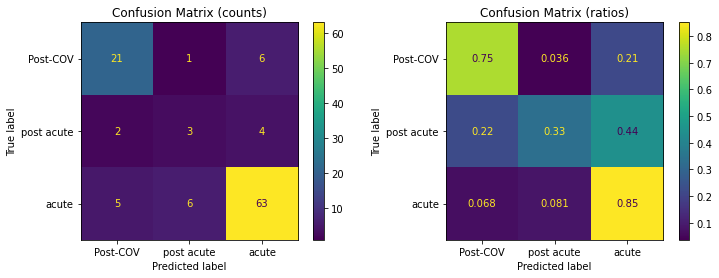

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te_12d_rescaled), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te_12d_rescaled), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** The model fit on the data with the PCA-reduced dimensionality gives slightly lower test accuracy 78.38%, but overall overfits less than the model fit on data with all features. The model predicts 10 patients in the post-acute phase rather than 13 (model with all features). The recall is slightly higher here when predicting patients in the acute phase of infection and lower when predicting the Post-COVID patients.